In [2]:
from PIL import Image
from glob import glob
import numpy as np
from droplet_growth import multiwell
from droplet_growth.register import filter_by_fft
from segment import seg
from skimage.color import label2rgb
from skimage.transform import rotate as _rotate
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import os

from skimage.morphology import convex_hull_image

%load_ext autoreload
%autoreload 2

In [1]:
muvipath = '/home/aaristov/Multicell1/Sebastien/mESC_aggregates/SUMO/SOX1-T_Movie/K12/POINT 00001/'

In [115]:
os.path.join(muvipath, '*/')

'/home/aaristov/Multicell1/Sebastien/mESC_aggregates/SUMO/SOX1-T_Movie/K12/POINT 00001/*/'

In [110]:
glob('/home/aaristov/Multicell1/Sebastien/mESC_aggregates/SUMO/SOX1-T_Movie/K12/POINT 00001/*/00001.JPG')

['/home/aaristov/Multicell1/Sebastien/mESC_aggregates/SUMO/SOX1-T_Movie/K12/POINT 00001/GFP/00001.JPG',
 '/home/aaristov/Multicell1/Sebastien/mESC_aggregates/SUMO/SOX1-T_Movie/K12/POINT 00001/BRIGHT/00001.JPG',
 '/home/aaristov/Multicell1/Sebastien/mESC_aggregates/SUMO/SOX1-T_Movie/K12/POINT 00001/RFP/00001.JPG']

In [142]:
def get_channels(path):
    return sorted([os.path.split(os.path.split(p)[0])[-1] for p in glob(os.path.join(path, '*/'))])

In [143]:
channels = get_channels(muvipath)

In [297]:
channels + ["MASK"]

['BRIGHT', 'GFP', 'RFP', 'MASK']

In [229]:
channels.index('RFP')

2

In [144]:
seg_ch = 'BRIGHT'

In [145]:
def get_paths(path, channels):
    f_list = {ch: sorted(glob(os.path.join(path, ch, '*.JPG'))) for ch in channels}
    grouped_list = [{ch: f_list[ch][i] for ch in channels} for i in range(len(f_list[channels[0]]))]
    return grouped_list

In [146]:
grouped_paths = get_paths(muvipath, channels)

In [233]:
list(grouped_paths[0].keys()).index('RFP')

2

In [391]:
def segment_bf(well, thr=0.5, smooth=10, erode=10, fill=True, plot=False):
    '''
    Serments input 2d array using thresholded gradient with filling
    Returns SegmentedImage object
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    print(f'{n_labels} regions')
    if plot:
        fig, ax = multiwell.plt.subplots(1,2)
        ax[0].imshow(sm, cmap='gray')
        ax[1].imshow(labels)
        plt.show()
        
    return labels

def get_biggest_region(labels):
    props = seg.regionprops(labels)
    return labels == props[np.argmax([p.area for p in props])].label

def get_convex(mask):
    return convex_hull_image(mask)

def get_contour(mask, size=1, overlay_image=None):
    contour = np.logical_xor(mask, seg.binary_erosion(mask, np.ones((size, size))))
    if overlay_image is not None:
        plt.imshow(label2rgb(contour, overlay_image, bg_label=0))
        plt.show()
    return contour

def segment_jpg(path, thr=.5, smooth=10, plot=True, contour=20):
    img = np.array(Image.open(path))
    if smooth > 0:
        sm_img = seg.gaussian_filter(img, smooth)
    mask = segment_bf((sm_img), thr=thr, plot=plot)
    big = get_biggest_region(mask)
    if plot:
        plt.imshow(big)
        plt.show()
#     plt.imshow(conv := get_convex(big))
#     plt.show()
        contour = get_contour(big, size=contour, overlay_image=img)
    return img, big

def sub_bg(img:np.ndarray, smooth=50):
    img = img.astype('float32')
    if smooth:
        return img - seg.gaussian_filter(img, smooth)
    return img - img.min()

1 regions


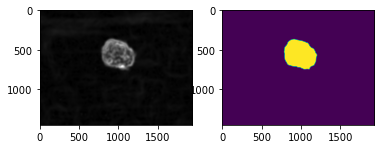

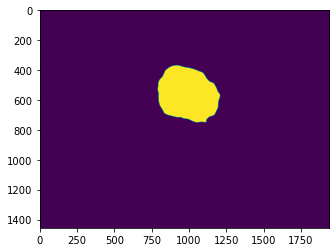

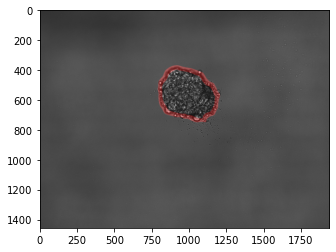

1 regions


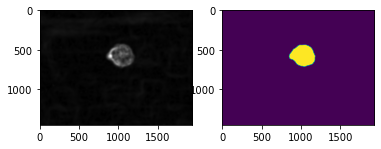

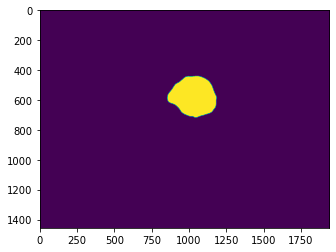

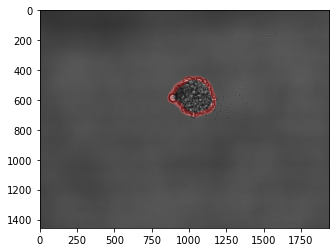

1 regions


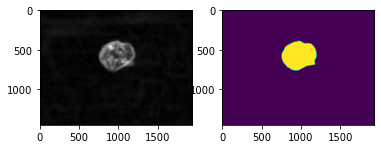

1 regions


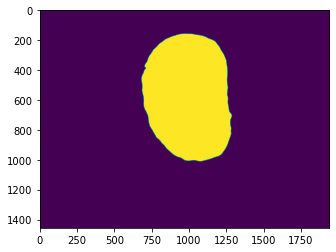

1 regions


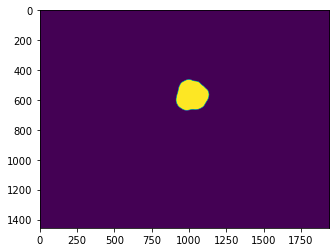

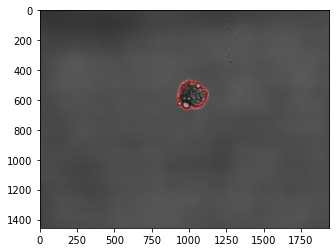

2 regions


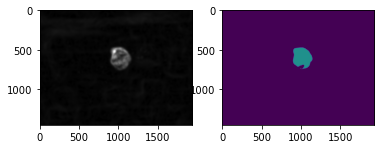

1 regions


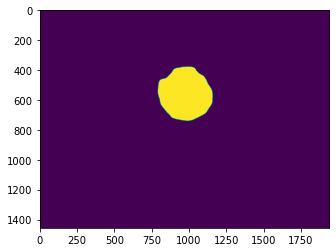

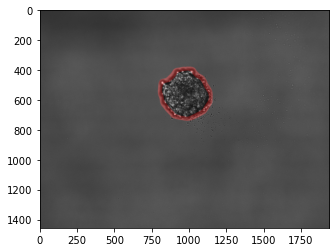

1 regions


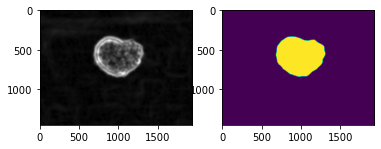

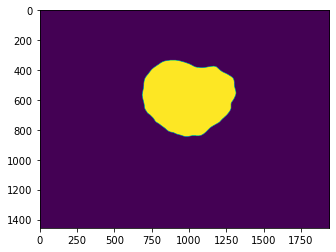

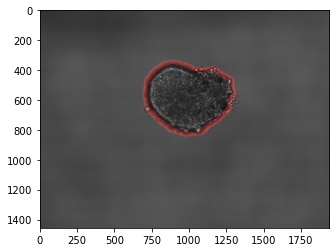

1 regions


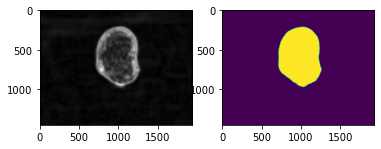

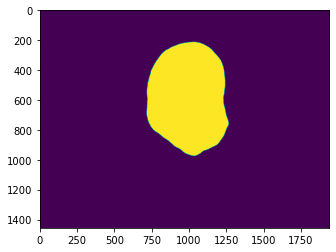

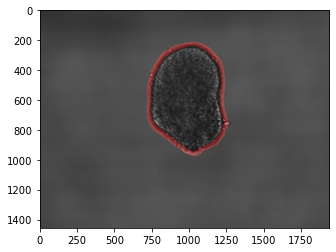

1 regions


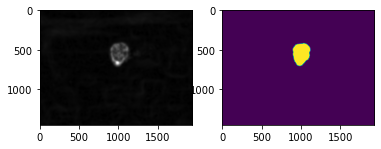

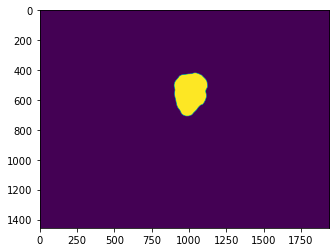

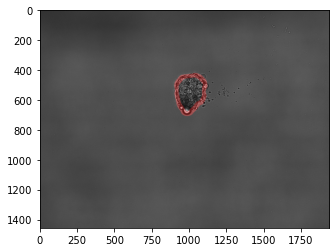

1 regions


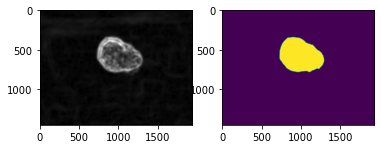

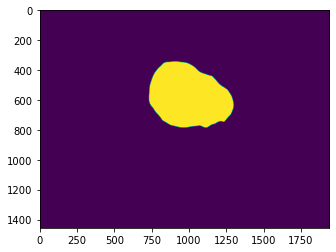

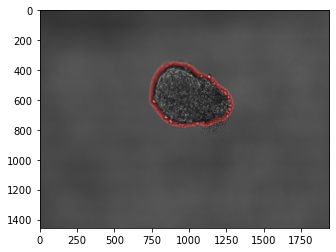

1 regions


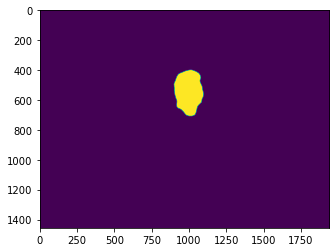

1 regions


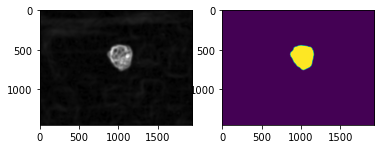

1 regions


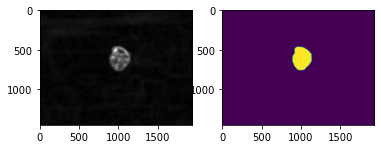

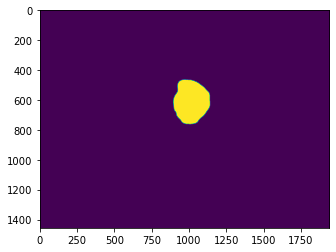

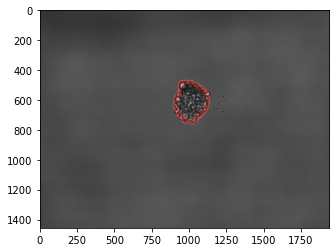

1 regions


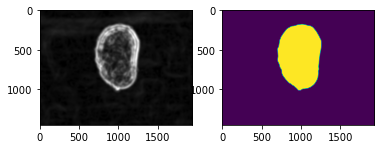

1 regions


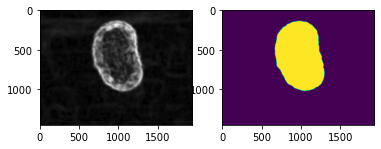

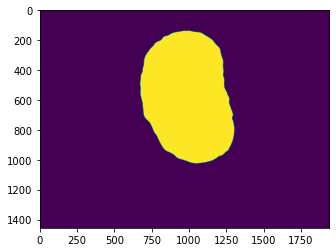

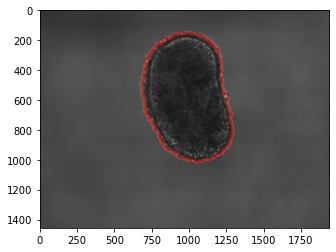

1 regions


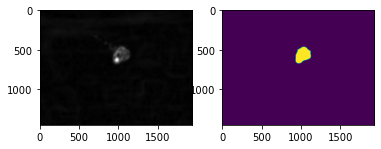

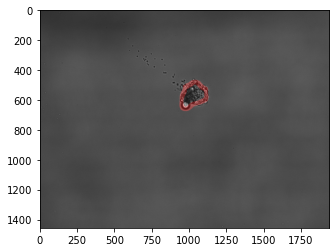

3 regions


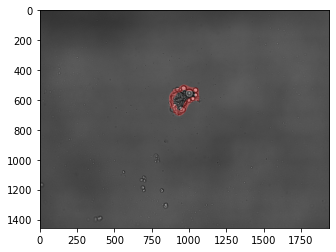

1 regions


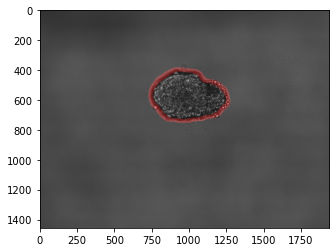

1 regions


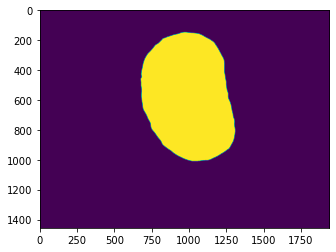

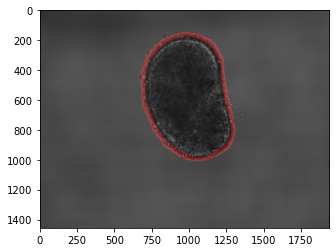

1 regions


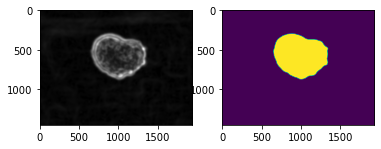

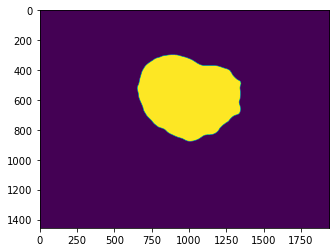

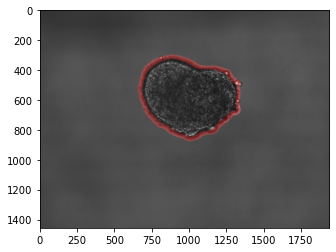

1 regions


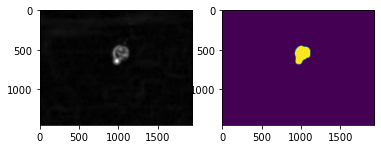

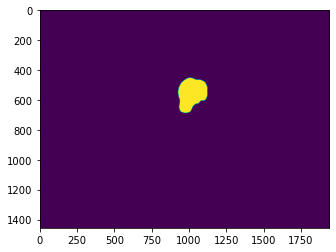

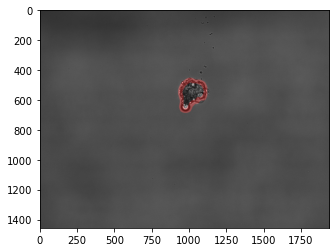

3 regions


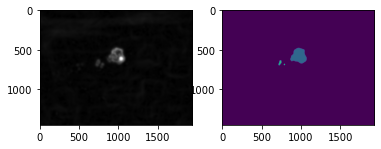

1 regions


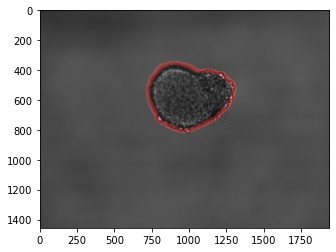

1 regions


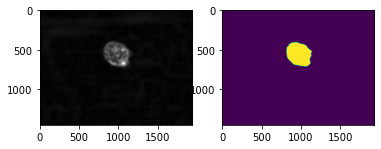

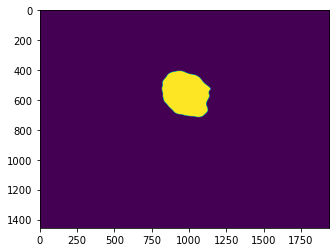

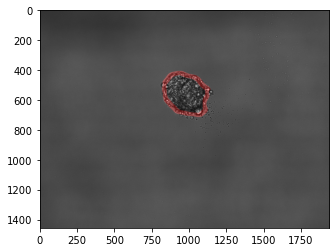

1 regions


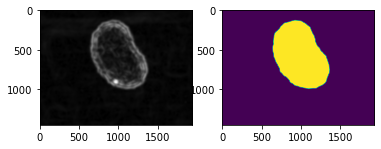

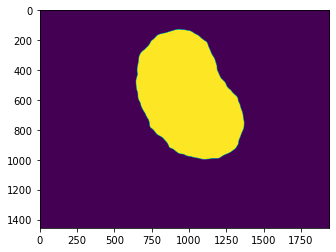

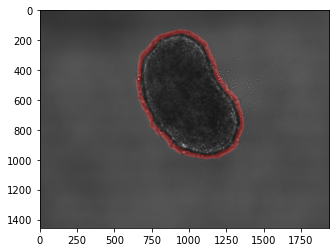

1 regions


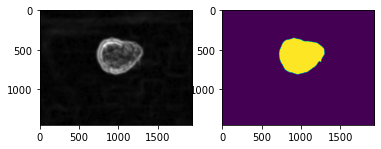

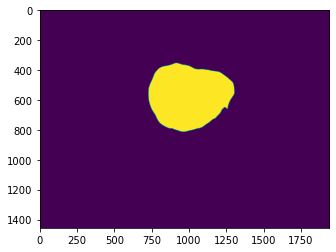

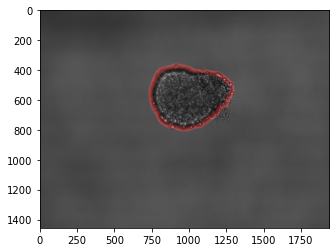

1 regions


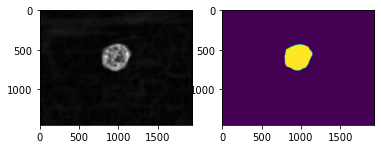

1 regions


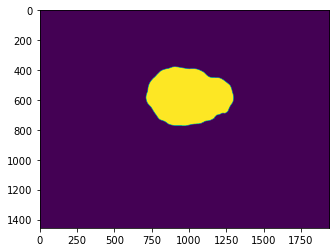

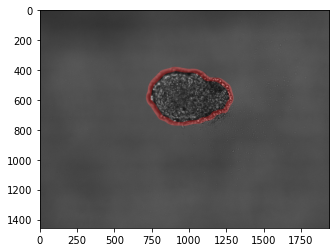

1 regions


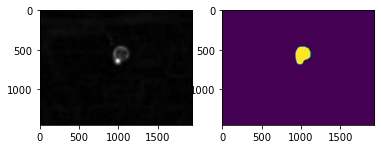

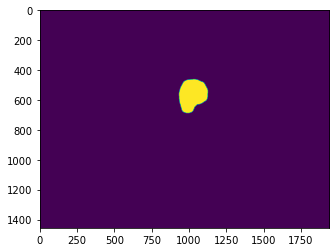

1 regions


1 regions


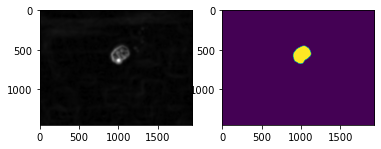

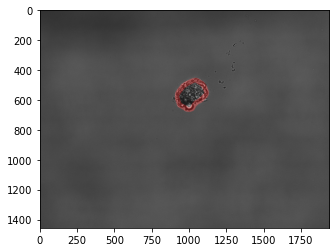

1 regions


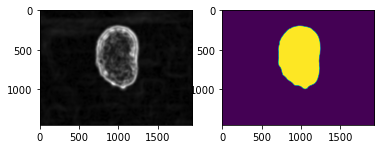

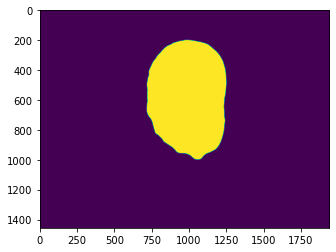

2 regions


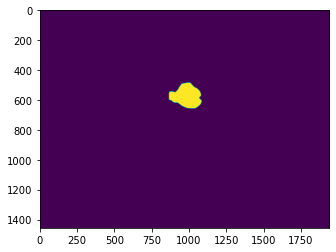

1 regions


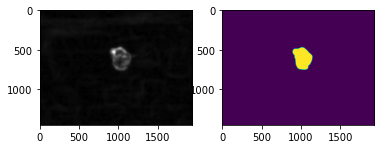

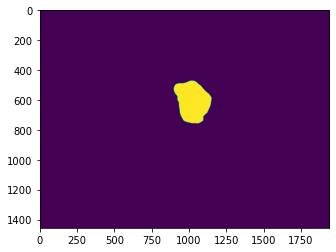

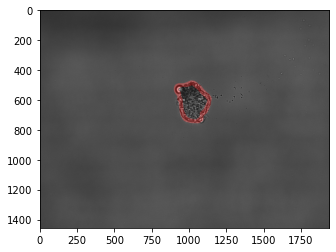

1 regions


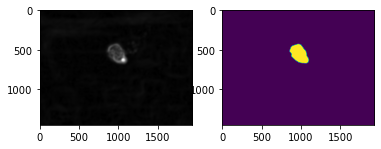

1 regions


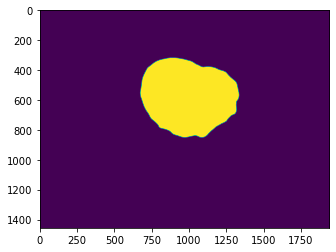

1 regions


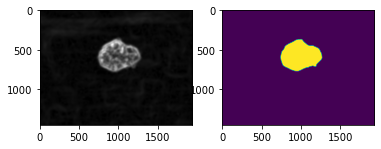

1 regions


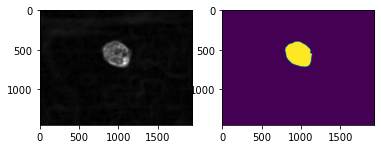

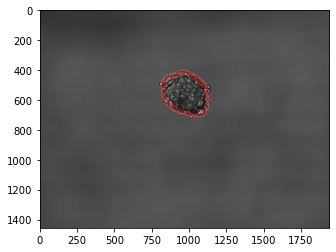

1 regions


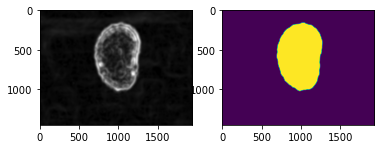

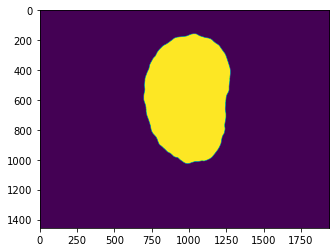

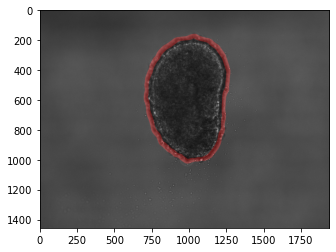

In [89]:
masks = list(map(segment_jpg, paths))

In [318]:
def get_max_pos2D(a:np.ndarray):
    return np.unravel_index(np.argmax(a, axis=None), a.shape)


def rotate_organoid(grouped_path, seg_ch='BRIGHT', orient='GFP', plot=False):
    bf, mask = segment_jpg(grouped_path[seg_ch], plot=plot)
    props = seg.regionprops(seg.label(mask))
    rotated = [rotate(sub_bg(np.array(Image.open(path)), 150), props[0]) for path in grouped_path.values()] + \
                [rotate(mask, props[0]).astype('uint8')]
    
#     try:
    index = list(grouped_path.keys()).index(orient)
    mmm = get_max_pos2D(rotated[index])
    print(mmm)
    if mmm[1] > rotated[0].shape[1] // 2:
        rotated1 = [_rotate(r, 180, preserve_range=True) for r in rotated]
        rotated = rotated1
#     except Exception as e:
#         print(f'Failed to align using `{orient}`', e.args)
    
    if plot:
        fig, ax = plt.subplots(ncols=len(rotated), figsize=(10,3), dpi=150)
        for a, img in zip(ax, rotated):
            im1 = a.imshow(img)
            fig.colorbar(im1, ax=a)
    return np.array(rotated)

In [218]:
def move_to_center(img, centroid):
    shape = img.shape
    cyx = np.array(shape, dtype='int') // 2
    dy, dx = np.array(centroid, dtype='int') - cyx
    padded = np.pad(img, ((abs(dy), abs(dy)), (abs(dx), abs(dx))), mode='edge')
    return padded[abs(dy) + dy : -1 + dy - abs(dy), abs(dx) + dx : -1 + dx - abs(dx)]

In [227]:
def rotate(img, prop, add=0):
    centered = move_to_center(img, prop.centroid)
    angle = -prop.orientation / np.pi * 180 - 90 + add
    return _rotate(centered, angle, preserve_range=True, resize=False, center=None)

3 regions


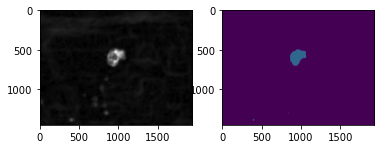

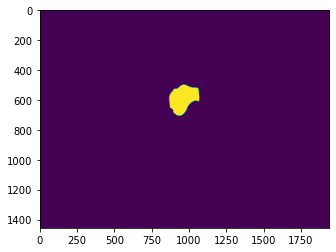

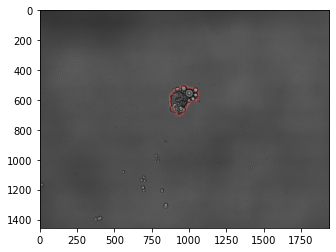

(0, 322)


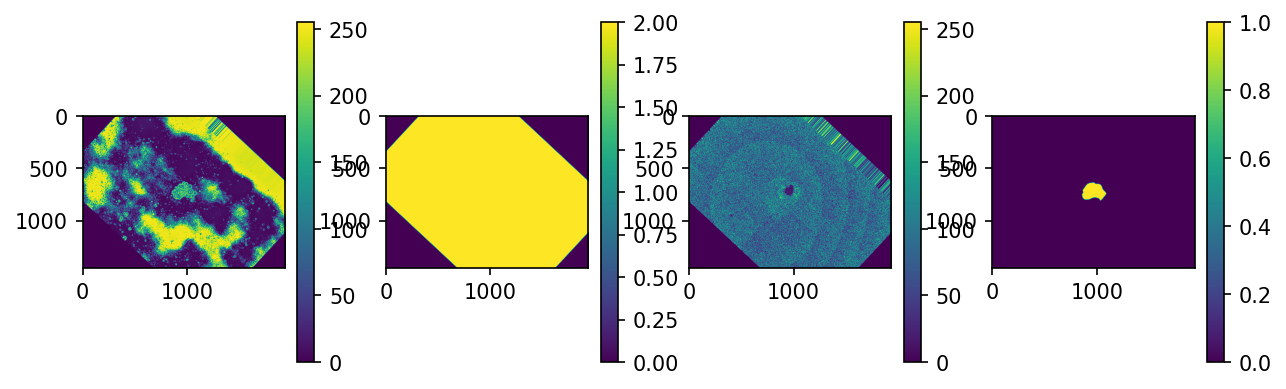

In [371]:
rotated = rotate_organoid(grouped_paths[0], plot=True)


In [310]:
rotated_orgs = list(map(rotate_organoid, grouped_paths))

3 regions
(0, 0)
3 regions
(507, 0)
2 regions
(161, 0)
1 regions
(199, 4)
1 regions
(1067, 1871)
1 regions
(1213, 1739)
1 regions
(1243, 1387)
1 regions
(138, 1742)
1 regions
(1241, 1210)
1 regions
(1107, 686)
1 regions
(775, 920)
1 regions
(744, 936)
1 regions
(745, 1019)
2 regions
(768, 1031)
1 regions
(735, 1036)
1 regions
(761, 1019)
1 regions
(695, 1051)
1 regions
(645, 954)
1 regions
(638, 884)
1 regions
(743, 1019)
1 regions
(745, 957)
1 regions
(797, 857)
1 regions
(659, 1096)
1 regions
(673, 1154)
1 regions
(796, 790)
1 regions
(810, 800)
1 regions
(792, 778)
1 regions
(655, 1144)
1 regions
(790, 766)
1 regions
(857, 744)
1 regions
(764, 753)
1 regions
(753, 730)
1 regions
(752, 658)
1 regions
(818, 722)
1 regions
(782, 654)
1 regions
(818, 627)
1 regions
(772, 668)
1 regions
(793, 664)
1 regions
(836, 642)
1 regions
(818, 744)


In [191]:
from nd2tif.transform import Well

In [313]:
w = Well(np.array(rotated_orgs, dtype='float32'), order='tcyx')

In [314]:
w.save_tif('/home/aaristov/Multicell1/Sebastien/mESC_aggregates/SUMO/SOX1-T_Movie/K12/POINT 00001/test-bg-sm150-GFP.tif')

In [206]:
img = Image.open(grouped_paths[0]['BRIGHT'])

In [208]:
img.bits

8

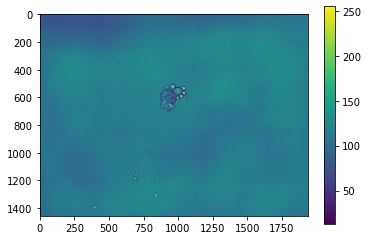

In [213]:
plt.imshow(np.array(img,))
plt.colorbar()

In [317]:
rotated_orgs[0].shape

(4, 1455, 1935)

In [373]:
%time seg.gaussian_filter(rotated_orgs[0][0], 2)

CPU times: user 49.1 ms, sys: 13 µs, total: 49.1 ms
Wall time: 47 ms


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [374]:
%time seg.gaussian_filter(rotated_orgs[0][0], 20)

CPU times: user 403 ms, sys: 0 ns, total: 403 ms
Wall time: 402 ms


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [375]:
%time seg.gaussian_filter(rotated_orgs[0][0], 200)

CPU times: user 4.19 s, sys: 3.49 ms, total: 4.19 s
Wall time: 4.19 s


array([[-0.68571436, -0.68569165, -0.68564606, ..., -0.5405489 ,
        -0.540491  , -0.5404619 ],
       [-0.6857204 , -0.6856977 , -0.6856521 , ..., -0.5405954 ,
        -0.5405374 , -0.5405084 ],
       [-0.6857321 , -0.68570936, -0.68566376, ..., -0.5406885 ,
        -0.5406305 , -0.5406015 ],
       ...,
       [ 0.10796362,  0.10797229,  0.10798987, ...,  0.28102297,
         0.2809896 ,  0.28097302],
       [ 0.10795638,  0.10796504,  0.10798263, ...,  0.2809856 ,
         0.2809522 ,  0.28093565],
       [ 0.10795283,  0.10796149,  0.10797907, ...,  0.28096685,
         0.28093347,  0.2809169 ]], dtype=float32)

In [376]:
%time np.fft.fft(rotated_orgs[0][0])

CPU times: user 62.6 ms, sys: 8.41 ms, total: 71 ms
Wall time: 132 ms


array([[-1790.00922655   +0.j        ,  2744.6730149 -2600.94336582j,
        -4474.47716125+2432.1624954j , ...,
         3840.11957585 -535.73974248j, -4474.47716125-2432.1624954j ,
         2744.6730149 +2600.94336582j],
       [-1839.82307161   +0.j        ,  2771.26363136-2562.07892175j,
        -4449.87037356+2389.52185399j, ...,
         3794.26178581 -538.35252497j, -4449.87037356-2389.52185399j,
         2771.26363136+2562.07892175j],
       [-1820.78373323   +0.j        ,  2757.97246027-2597.32850964j,
        -4466.53247007+2446.46823682j, ...,
         3836.00979959 -503.24088547j, -4466.53247007-2446.46823682j,
         2757.97246027+2597.32850964j],
       ...,
       [ 1547.11727178   +0.j        , -1205.4443672  -584.87006334j,
          811.04554591+1347.27151196j, ...,
         -980.69537558+1349.27820961j,   811.04554591-1347.27151196j,
        -1205.4443672  +584.87006334j],
       [ 1464.60411016   +0.j        , -1166.29441602 -598.34186657j,
          810.96200468

In [435]:
%time fff = filter_by_fft(rotated_orgs[0][0].astype('float32'), sigma=20, highpass=False )

CPU times: user 1.73 s, sys: 185 ms, total: 1.91 s
Wall time: 1.91 s


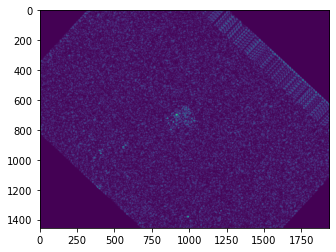

In [436]:
plt.imshow(fff)

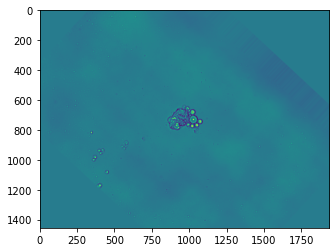

In [401]:
plt.imshow(rotated_orgs[0][0])

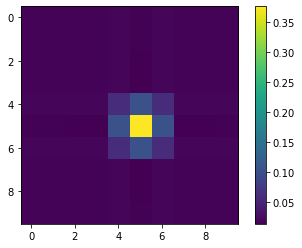

In [439]:
test = np.zeros((10,10))
test[5,5] = 1
plt.imshow(filter_by_fft(test+1, 4, highpass=False))
plt.colorbar()

In [352]:
def get_maxima(rotated_stack, channels=[1,2]):
    mask = rotated_stack[3]
    ch1,ch2 = [rotated_stack[i] * mask for i in channels]
    cx = ch1.shape[1] // 2
    max_proj_x = [ch.max(axis=0) for ch in (ch1, ch2)]
    peaks_x = [_get_peak_position(mp, min_val=2, default_position=cx, smooth=10) - cx for mp in max_proj_x]
#     plt.plot(max_proj_x[0])
#     plt.plot(max_proj_x[1])
#     plt.show()
    return peaks_x

def _get_peak_position(proj, min_val=2, default_position=0, smooth=10):
    if proj.max() < min_val:
        return default_position
    return np.argmax(gaussian_filter1d(proj, smooth))

In [363]:
peaks = np.array([get_maxima(r) for r in rotated_orgs[:]])

In [364]:
peaks

array([[   0,   -2],
       [   0,  -12],
       [   0,   -3],
       [   0,  -22],
       [   0,   38],
       [   0,   45],
       [ -46,   58],
       [ -90,   69],
       [ -80,   71],
       [ -51,  -69],
       [ -51,  -67],
       [ -53,  -85],
       [ -48,    4],
       [ -56,  -66],
       [ -68,   15],
       [ -62,   26],
       [ -84,   30],
       [ -16,   -7],
       [ -81,   20],
       [  -5,   27],
       [ -14,   35],
       [-113,   78],
       [-127,   92],
       [-184,   98],
       [-182,   89],
       [-173,  148],
       [-187,  149],
       [-205,  140],
       [-224,  159],
       [-218,  200],
       [-225,  232],
       [-245,  257],
       [-279,  247],
       [-244,  152],
       [-325,  192],
       [-330,  195],
       [-316,  110],
       [-307,  116],
       [-284,  160],
       [-226,  179]])

Text(0.5, 0, 'time, h')

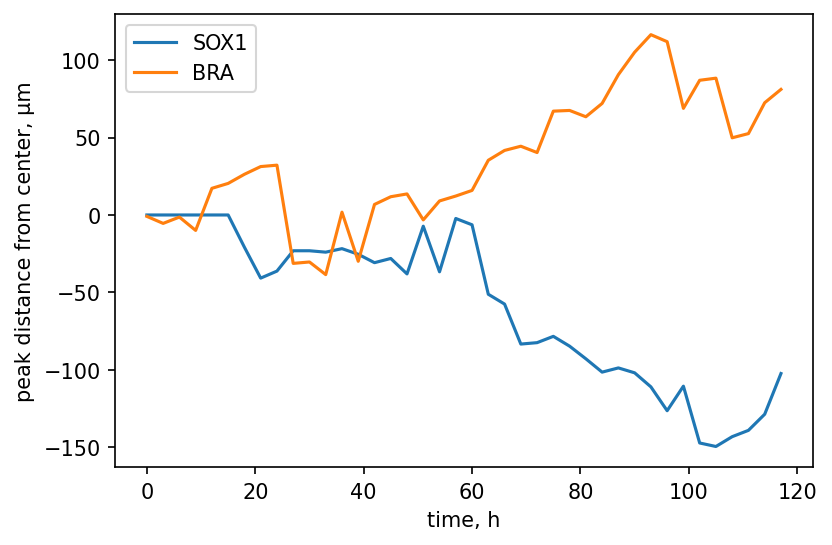

In [369]:
fig, ax = plt.subplots(dpi=150)
time = np.arange(0, len(peaks)) * 3
px_size = .453 #um
plt.plot(time, peaks[:,0] * px_size, label='SOX1')
plt.plot(time, peaks[:,1] * px_size, label='BRA')
plt.legend()
plt.ylabel('peak distance from center, μm')
plt.xlabel('time, h')